## DQN train notebook

In [8]:
import numpy as np
from cube import Cube
from tqdm import tqdm
from q_network import QNetwork
import torch
from copy import deepcopy
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
episodes = 10000
episode_len = 5
scramble_steps = 2

lr = 0.0001
buffer_size = 10000
batch_len = 32
gamma = 0.9
epsilon = 0.1
target_update_interval = 100
learning_starts = 100

avg_interval = 25

In [10]:
Q_net = QNetwork().to(device)
Q_net.train()

Q_target_net = deepcopy(Q_net)

optim = torch.optim.SGD(Q_net.parameters(), lr = lr)

replay_buffer = []

In [11]:
action_encode = {
    'F': 0,
    'F\'': 1,
    'B' : 2,
    'B\'': 3,
    'L' : 4,
    'L\'': 5,
    'R' : 6,
    'R\'': 7,
    'U' : 8,
    'U\'': 9,
    'D' : 10,
    'D\'': 11,
}
action_decode = {encoding : action for action, encoding in action_encode.items()}

def normalize_state(state):
    return (state - 2.5) / 2.5

In [12]:
iters_since_target_update = 0
it = 0
eps_since_last_avg = 0
ep_average_reward = 0
ep_average_loss = 0
ep_average_rewards = []
ep_average_losses = []
for ep in tqdm(range(episodes)):
    cube = Cube()
    cube.scramble(scramble_steps)
    s = np.copy(cube.facelets)
    
    for i in range(episode_len):
        with torch.no_grad():
            Q_pred = Q_net(torch.Tensor(normalize_state(s))[None, :].to(device))
        
        a = torch.argmax(Q_pred).item()
        if np.random.uniform() < epsilon:
            a = np.random.randint(12)
        
        r = cube.rotate_code_get_reward(action_decode[a])
        s_prime = np.copy(cube.facelets)
        
        replay_buffer.append({'s': s, 'a': a, 'r': r, 's_prime': s_prime})
        if len(replay_buffer) > buffer_size:
            replay_buffer.pop(0)
        
        s = s_prime
        it += 1
        
        if it >= learning_starts:
            batch = np.random.choice(replay_buffer, batch_len, replace = False)
            batch_s = np.array([x['s'] for x in batch])
            batch_a = np.array([x['a'] for x in batch])
            batch_r = np.array([x['r'] for x in batch])
            batch_r = torch.Tensor(batch_r).to(device)
            batch_s_prime = np.array([x['s_prime'] for x in batch])
            
            Q_hat = Q_net(torch.Tensor(normalize_state(batch_s)).to(device))[range(batch_len), torch.Tensor(batch_a).to(device).long()]
            
            with torch.no_grad():
                Q_target = batch_r + gamma * torch.max(Q_target_net(torch.Tensor(normalize_state(batch_s_prime)).to(device)), axis = 1).values
                for j in range(batch_len):
                    if cube.is_solved_state(batch_s_prime[j]):
                        Q_target[j] = batch_r[j]
            
            optim.zero_grad()
            loss = torch.nn.MSELoss()(Q_hat, Q_target)
            # print(loss)
            loss.backward()
            
            optim.step()
            
            iters_since_target_update += 1
            if iters_since_target_update >= target_update_interval:
                Q_target_net = deepcopy(Q_net)
                iters_since_target_update = 0
            
            ep_average_reward += r
            ep_average_loss += loss.item()
            # print("LOSS",loss.item())
        
        if cube.is_solved_state(s):
            break
            
    eps_since_last_avg += 1
    if eps_since_last_avg >= avg_interval:
        ep_average_rewards.append(ep_average_reward / avg_interval)
        ep_average_losses.append(ep_average_loss / avg_interval)
        print(ep_average_losses[-1])
        ep_average_reward = 0
        ep_average_loss = 0
        eps_since_last_avg = 0

  0%|          | 20/10000 [00:00<00:51, 195.29it/s]

135.31920639038086


  1%|          | 59/10000 [00:00<03:04, 53.86it/s] 

688.9206105804443


  1%|          | 84/10000 [00:01<03:23, 48.81it/s]

646.3415812683105


  1%|          | 105/10000 [00:02<03:57, 41.58it/s]

641.7532791900635


  1%|▏         | 130/10000 [00:02<03:38, 45.25it/s]

602.1906234741211


  2%|▏         | 155/10000 [00:03<03:35, 45.61it/s]

592.7722345733642


  2%|▏         | 180/10000 [00:03<03:41, 44.30it/s]

603.8005895996093


  2%|▏         | 205/10000 [00:04<03:29, 46.66it/s]

552.5975004577637


  2%|▏         | 230/10000 [00:04<03:31, 46.17it/s]

562.5857765197754


  3%|▎         | 255/10000 [00:05<03:33, 45.72it/s]

637.2617465972901


  3%|▎         | 280/10000 [00:05<03:34, 45.37it/s]

630.642089767456


  3%|▎         | 305/10000 [00:06<03:46, 42.72it/s]

608.2576438903809


  3%|▎         | 330/10000 [00:07<03:41, 43.69it/s]

572.0224622344971


  4%|▎         | 355/10000 [00:07<03:38, 44.20it/s]

554.0701101684571


  4%|▍         | 380/10000 [00:08<03:33, 44.97it/s]

571.903666267395


  4%|▍         | 405/10000 [00:08<03:32, 45.25it/s]

564.9680711364746


  4%|▍         | 430/10000 [00:09<03:30, 45.36it/s]

556.2847133636475


  5%|▍         | 455/10000 [00:09<03:34, 44.57it/s]

543.7676426696777


  5%|▍         | 480/10000 [00:10<03:34, 44.45it/s]

540.6937884521484


  5%|▌         | 505/10000 [00:10<03:32, 44.58it/s]

520.58369140625


  5%|▌         | 530/10000 [00:11<03:31, 44.85it/s]

554.5931349945068


  6%|▌         | 555/10000 [00:12<03:37, 43.45it/s]

604.7179761505126


  6%|▌         | 580/10000 [00:12<03:35, 43.75it/s]

515.5489237213135


  6%|▌         | 605/10000 [00:13<03:49, 40.88it/s]

572.2612259674072


  6%|▋         | 630/10000 [00:13<03:49, 40.85it/s]

521.8923272705078


  7%|▋         | 654/10000 [00:14<03:55, 39.73it/s]

523.271799659729


  7%|▋         | 682/10000 [00:15<03:58, 39.13it/s]

513.0966887664795


  7%|▋         | 707/10000 [00:15<03:58, 38.95it/s]

628.586521911621


  7%|▋         | 731/10000 [00:16<04:00, 38.48it/s]

494.05535987854006


  8%|▊         | 757/10000 [00:17<03:52, 39.70it/s]

514.3308911132813


  8%|▊         | 780/10000 [00:17<03:44, 41.07it/s]

642.5599848175049


  8%|▊         | 804/10000 [00:18<03:51, 39.69it/s]

536.7999151611328


  8%|▊         | 833/10000 [00:19<03:54, 39.10it/s]

557.351481552124


  9%|▊         | 858/10000 [00:19<03:52, 39.39it/s]

575.3793717956543


  9%|▉         | 881/10000 [00:20<03:47, 40.11it/s]

564.3399349975585


  9%|▉         | 906/10000 [00:20<03:46, 40.12it/s]

531.6294425964355


  9%|▉         | 930/10000 [00:21<03:49, 39.49it/s]

606.0157564544678


 10%|▉         | 955/10000 [00:22<03:41, 40.87it/s]

622.6753622436523


 10%|▉         | 980/10000 [00:22<03:43, 40.41it/s]

554.6196336364746


 10%|█         | 1005/10000 [00:23<03:59, 37.56it/s]

561.4500852966308


 10%|█         | 1030/10000 [00:24<03:53, 38.35it/s]

585.7989867401124


 11%|█         | 1057/10000 [00:24<03:39, 40.67it/s]

666.9363135528564


 11%|█         | 1081/10000 [00:25<03:45, 39.50it/s]

580.9701997375488


 11%|█         | 1105/10000 [00:25<03:48, 38.90it/s]

617.9725061035156


 11%|█▏        | 1129/10000 [00:26<03:50, 38.47it/s]

638.3400396728516


 12%|█▏        | 1155/10000 [00:27<03:46, 39.02it/s]

680.8667399597168


 12%|█▏        | 1179/10000 [00:27<03:51, 38.06it/s]

604.759945602417


 12%|█▏        | 1207/10000 [00:28<03:48, 38.48it/s]

581.7164231872558


 12%|█▏        | 1231/10000 [00:29<03:51, 37.91it/s]

643.5425727844238


 13%|█▎        | 1255/10000 [00:29<03:52, 37.59it/s]

563.9782569122315


 13%|█▎        | 1279/10000 [00:30<03:53, 37.34it/s]

602.2527771759034


 13%|█▎        | 1307/10000 [00:31<03:52, 37.38it/s]

599.4301161193848


 13%|█▎        | 1331/10000 [00:31<03:54, 36.90it/s]

569.9494909667969


 14%|█▎        | 1355/10000 [00:32<03:48, 37.86it/s]

622.5237822723388


 14%|█▍        | 1379/10000 [00:33<03:50, 37.34it/s]

565.3258993530274


 14%|█▍        | 1407/10000 [00:34<03:54, 36.59it/s]

610.2092971038818


 14%|█▍        | 1431/10000 [00:34<03:46, 37.85it/s]

559.898698348999


 15%|█▍        | 1456/10000 [00:35<03:49, 37.19it/s]

568.0923277282715


 15%|█▍        | 1480/10000 [00:35<03:53, 36.50it/s]

548.6032801437378


 15%|█▌        | 1504/10000 [00:36<03:50, 36.89it/s]

522.3435620880127


 15%|█▌        | 1532/10000 [00:37<03:47, 37.24it/s]

543.6413402557373


 16%|█▌        | 1556/10000 [00:38<03:49, 36.72it/s]

478.2737661743164


 16%|█▌        | 1580/10000 [00:38<03:54, 35.90it/s]

488.58604743957517


 16%|█▌        | 1604/10000 [00:39<03:54, 35.82it/s]

500.42543022155763


 16%|█▋        | 1632/10000 [00:40<03:51, 36.07it/s]

465.64573181152343


 17%|█▋        | 1656/10000 [00:40<03:49, 36.28it/s]

365.3819236755371


 17%|█▋        | 1680/10000 [00:41<03:52, 35.82it/s]

404.772427406311


 17%|█▋        | 1704/10000 [00:42<03:52, 35.62it/s]

426.9342728042603


 17%|█▋        | 1732/10000 [00:42<03:54, 35.28it/s]

420.44843101501465


 18%|█▊        | 1756/10000 [00:43<03:54, 35.12it/s]

345.3395894622803


 18%|█▊        | 1780/10000 [00:44<03:57, 34.62it/s]

366.5907649230957


 18%|█▊        | 1804/10000 [00:45<03:55, 34.81it/s]

329.65239810943604


 18%|█▊        | 1832/10000 [00:45<03:52, 35.17it/s]

303.0186907196045


 19%|█▊        | 1856/10000 [00:46<03:56, 34.46it/s]

396.5659355545044


 19%|█▉        | 1880/10000 [00:47<03:56, 34.30it/s]

281.6007556152344


 19%|█▉        | 1904/10000 [00:47<03:56, 34.17it/s]

263.515537109375


 19%|█▉        | 1932/10000 [00:48<03:55, 34.32it/s]

303.1943394851685


 20%|█▉        | 1956/10000 [00:49<03:53, 34.43it/s]

323.53520904541017


 20%|█▉        | 1980/10000 [00:50<03:51, 34.68it/s]

299.2943701171875


 20%|██        | 2004/10000 [00:50<03:58, 33.47it/s]

283.271460647583


 20%|██        | 2028/10000 [00:51<03:55, 33.88it/s]

306.7311743164062


 21%|██        | 2056/10000 [00:52<03:55, 33.70it/s]

280.67522480010985


 21%|██        | 2080/10000 [00:53<03:57, 33.41it/s]

234.99369449615477


 21%|██        | 2104/10000 [00:53<04:01, 32.76it/s]

243.6993095397949


 21%|██▏       | 2128/10000 [00:54<03:58, 33.07it/s]

229.190989112854


 22%|██▏       | 2156/10000 [00:55<03:55, 33.37it/s]

262.4660330581665


 22%|██▏       | 2180/10000 [00:56<03:54, 33.33it/s]

242.33671726226805


 22%|██▏       | 2204/10000 [00:56<03:40, 35.40it/s]

277.71981147766115


 22%|██▏       | 2232/10000 [00:57<03:32, 36.57it/s]

276.7215352630615


 23%|██▎       | 2256/10000 [00:58<03:32, 36.45it/s]

276.34362590789794


 23%|██▎       | 2280/10000 [00:58<03:30, 36.64it/s]

251.69567405700684


 23%|██▎       | 2304/10000 [00:59<03:29, 36.81it/s]

182.63807468414308


 23%|██▎       | 2332/10000 [01:00<03:33, 35.84it/s]

238.4020257949829


 24%|██▎       | 2356/10000 [01:01<03:32, 35.89it/s]

249.32353324890136


 24%|██▍       | 2380/10000 [01:01<03:32, 35.90it/s]

192.78171562194825


 24%|██▍       | 2404/10000 [01:02<03:32, 35.67it/s]

187.19701732635497


 24%|██▍       | 2432/10000 [01:03<03:33, 35.37it/s]

219.70452960968018


 25%|██▍       | 2456/10000 [01:03<03:40, 34.15it/s]

170.35170028686522


 25%|██▍       | 2480/10000 [01:04<03:35, 34.86it/s]

181.23796508789061


 25%|██▌       | 2504/10000 [01:05<03:33, 35.07it/s]

169.5918070602417


 25%|██▌       | 2532/10000 [01:06<03:36, 34.48it/s]

236.47025505065918


 26%|██▌       | 2556/10000 [01:06<03:37, 34.17it/s]

152.68866130828857


 26%|██▌       | 2580/10000 [01:07<03:32, 34.89it/s]

191.56387378692628


 26%|██▌       | 2604/10000 [01:08<03:34, 34.56it/s]

157.61554458618164


 26%|██▋       | 2629/10000 [01:08<03:24, 36.08it/s]

181.10850246429445


 27%|██▋       | 2657/10000 [01:09<03:27, 35.38it/s]

137.61373008728026


 27%|██▋       | 2681/10000 [01:10<03:30, 34.84it/s]

160.5406900024414


 27%|██▋       | 2706/10000 [01:11<03:21, 36.13it/s]

148.59919940948487


 27%|██▋       | 2730/10000 [01:11<03:30, 34.46it/s]

335.39567684173585


 28%|██▊       | 2754/10000 [01:12<03:22, 35.82it/s]

316.4582479858398


 28%|██▊       | 2782/10000 [01:13<03:17, 36.54it/s]

254.27385360717773


 28%|██▊       | 2806/10000 [01:13<03:16, 36.58it/s]

359.5812928009033


 28%|██▊       | 2830/10000 [01:14<03:17, 36.33it/s]

266.6399902534485


 29%|██▊       | 2854/10000 [01:15<03:25, 34.79it/s]

214.13901920318602


 29%|██▉       | 2878/10000 [01:15<03:25, 34.66it/s]

323.7738138580322


 29%|██▉       | 2906/10000 [01:16<03:21, 35.22it/s]

307.191449508667


 29%|██▉       | 2931/10000 [01:17<03:15, 36.14it/s]

273.7572138595581


 30%|██▉       | 2956/10000 [01:18<03:18, 35.44it/s]

355.56532676696776


 30%|██▉       | 2980/10000 [01:18<03:21, 34.81it/s]

313.4865956878662


 30%|███       | 3004/10000 [01:19<03:20, 34.90it/s]

348.9375983810425


 30%|███       | 3029/10000 [01:20<03:13, 36.07it/s]

311.3515414047241


 31%|███       | 3053/10000 [01:20<03:18, 35.06it/s]

313.40084197998044


 31%|███       | 3081/10000 [01:21<03:24, 33.85it/s]

310.02881103515625


 31%|███       | 3101/10000 [01:22<03:35, 32.04it/s]

409.0857767486572


 31%|███▏      | 3130/10000 [01:23<03:45, 30.42it/s]

356.408876247406


 32%|███▏      | 3154/10000 [01:24<03:33, 32.08it/s]

304.83607692718505


 32%|███▏      | 3182/10000 [01:25<03:28, 32.64it/s]

398.4010371398926


 32%|███▏      | 3206/10000 [01:25<03:28, 32.57it/s]

316.1938695526123


 32%|███▏      | 3230/10000 [01:26<03:20, 33.82it/s]

361.67604900360107


 33%|███▎      | 3254/10000 [01:27<03:29, 32.25it/s]

465.8669665145874


 33%|███▎      | 3282/10000 [01:28<03:21, 33.33it/s]

336.67015617370606


 33%|███▎      | 3306/10000 [01:28<03:23, 32.86it/s]

440.1999110412598


 33%|███▎      | 3330/10000 [01:29<03:36, 30.79it/s]

558.2989894104004


 34%|███▎      | 3353/10000 [01:30<03:38, 30.42it/s]

396.1798994445801


 34%|███▍      | 3381/10000 [01:31<03:27, 31.85it/s]

485.92304397583007


 34%|███▍      | 3405/10000 [01:32<03:28, 31.58it/s]

516.4948177719116


 34%|███▍      | 3429/10000 [01:32<03:26, 31.87it/s]

525.6935195541382


 35%|███▍      | 3453/10000 [01:33<03:22, 32.26it/s]

495.175556640625


 35%|███▍      | 3478/10000 [01:34<03:19, 32.64it/s]

573.5515410995483


 35%|███▌      | 3507/10000 [01:35<02:58, 36.45it/s]

630.7768372344971


 35%|███▌      | 3531/10000 [01:35<03:03, 35.34it/s]

521.9080001449585


 36%|███▌      | 3555/10000 [01:36<03:09, 34.02it/s]

756.2803162384033


 36%|███▌      | 3579/10000 [01:37<03:11, 33.51it/s]

686.6001320266723


 36%|███▌      | 3603/10000 [01:38<03:04, 34.68it/s]

792.8486155700683


 36%|███▋      | 3631/10000 [01:38<03:06, 34.19it/s]

853.423576889038


 37%|███▋      | 3655/10000 [01:39<03:07, 33.89it/s]

975.8749082183838


 37%|███▋      | 3680/10000 [01:40<03:05, 34.15it/s]

922.9132846832275


 37%|███▋      | 3704/10000 [01:41<03:06, 33.74it/s]

925.1142687225342


 37%|███▋      | 3732/10000 [01:41<03:02, 34.40it/s]

956.8233541870118


 38%|███▊      | 3756/10000 [01:42<03:00, 34.51it/s]

1201.4884349822999


 38%|███▊      | 3780/10000 [01:43<03:06, 33.36it/s]

1307.5846845245362


 38%|███▊      | 3804/10000 [01:44<03:07, 33.12it/s]

1087.381361694336


 38%|███▊      | 3828/10000 [01:44<03:02, 33.82it/s]

1247.374013824463


 39%|███▊      | 3856/10000 [01:45<02:59, 34.30it/s]

1403.4260748291015


 39%|███▉      | 3880/10000 [01:46<03:02, 33.56it/s]

953.5512411499024


 39%|███▉      | 3904/10000 [01:47<02:59, 33.87it/s]

1165.9107118225097


 39%|███▉      | 3928/10000 [01:47<03:04, 32.86it/s]

981.7123373413086


 40%|███▉      | 3956/10000 [01:48<03:04, 32.75it/s]

899.6022265625


 40%|███▉      | 3981/10000 [01:49<02:59, 33.57it/s]

817.3668975830078


 40%|████      | 4005/10000 [01:50<02:53, 34.57it/s]

892.4271125793457


 40%|████      | 4030/10000 [01:50<02:50, 35.10it/s]

998.4896893310547


 41%|████      | 4054/10000 [01:51<02:42, 36.52it/s]

895.5362930297852


 41%|████      | 4078/10000 [01:52<02:46, 35.49it/s]

948.5738824462891


 41%|████      | 4106/10000 [01:53<03:06, 31.52it/s]

822.9307826232911


 41%|████▏     | 4130/10000 [01:53<03:02, 32.20it/s]

920.5726525878906


 42%|████▏     | 4154/10000 [01:54<03:01, 32.16it/s]

718.1139610290527


 42%|████▏     | 4179/10000 [01:55<02:55, 33.18it/s]

830.5464526367188


 42%|████▏     | 4207/10000 [01:56<02:50, 34.00it/s]

913.7431573486328


 42%|████▏     | 4231/10000 [01:56<02:45, 34.80it/s]

1058.0488046264647


 43%|████▎     | 4255/10000 [01:57<02:52, 33.22it/s]

1293.2732400512696


 43%|████▎     | 4279/10000 [01:58<02:51, 33.36it/s]

943.4202708435058


 43%|████▎     | 4304/10000 [01:59<02:41, 35.32it/s]

862.9378324127197


 43%|████▎     | 4328/10000 [01:59<02:40, 35.30it/s]

543.2830905151367


 44%|████▎     | 4356/10000 [02:00<02:41, 34.94it/s]

898.1988691711426


 44%|████▍     | 4380/10000 [02:01<02:49, 33.06it/s]

779.0344332885742


 44%|████▍     | 4404/10000 [02:01<02:43, 34.25it/s]

775.5838996887207


 44%|████▍     | 4432/10000 [02:02<02:34, 35.96it/s]

637.5845446777344


 45%|████▍     | 4457/10000 [02:03<02:26, 37.92it/s]

612.5356217956543


 45%|████▍     | 4482/10000 [02:04<02:26, 37.73it/s]

620.0157415771484


 45%|████▌     | 4506/10000 [02:04<02:41, 34.12it/s]

596.1877186584472


 45%|████▌     | 4530/10000 [02:05<02:36, 35.02it/s]

789.5122866821289


 46%|████▌     | 4554/10000 [02:06<02:40, 33.86it/s]

608.753226776123


 46%|████▌     | 4582/10000 [02:07<02:31, 35.84it/s]

483.71772338867186


 46%|████▌     | 4606/10000 [02:07<02:48, 32.03it/s]

494.5274957275391


 46%|████▋     | 4632/10000 [02:08<02:31, 35.49it/s]

528.2612882995605


 47%|████▋     | 4657/10000 [02:09<02:32, 35.01it/s]

437.23406448364256


 47%|████▋     | 4681/10000 [02:09<02:39, 33.30it/s]

433.6797155761719


 47%|████▋     | 4706/10000 [02:10<02:31, 34.87it/s]

540.641849975586


 47%|████▋     | 4730/10000 [02:11<02:30, 34.92it/s]

501.9535070800781


 48%|████▊     | 4755/10000 [02:12<02:33, 34.27it/s]

585.5981439208985


 48%|████▊     | 4779/10000 [02:12<02:33, 33.97it/s]

670.3578776550293


 48%|████▊     | 4804/10000 [02:13<02:32, 33.99it/s]

442.27455184936525


 48%|████▊     | 4832/10000 [02:14<02:27, 35.05it/s]

373.97192184448244


 49%|████▊     | 4856/10000 [02:15<02:30, 34.26it/s]

368.8653987121582


 49%|████▉     | 4880/10000 [02:15<02:29, 34.29it/s]

358.4501336669922


 49%|████▉     | 4904/10000 [02:16<02:24, 35.26it/s]

428.04573944091794


 49%|████▉     | 4929/10000 [02:17<02:22, 35.46it/s]

396.55149559021


 50%|████▉     | 4955/10000 [02:17<02:18, 36.44it/s]

361.2334856414795


 50%|████▉     | 4979/10000 [02:18<02:27, 34.09it/s]

387.52595275878906


 50%|█████     | 5008/10000 [02:19<02:11, 37.99it/s]

401.32409866333006


 50%|█████     | 5029/10000 [02:20<02:11, 37.91it/s]

343.695739440918


 51%|█████     | 5057/10000 [02:20<02:08, 38.35it/s]

341.6387577056885


 51%|█████     | 5084/10000 [02:21<02:03, 39.91it/s]

362.82428451538084


 51%|█████     | 5106/10000 [02:22<02:05, 38.86it/s]

366.1055944061279


 51%|█████▏    | 5131/10000 [02:22<02:10, 37.45it/s]

377.1177423095703


 52%|█████▏    | 5158/10000 [02:23<02:07, 37.98it/s]

436.1398550415039


 52%|█████▏    | 5179/10000 [02:24<02:08, 37.63it/s]

391.2661454772949


 52%|█████▏    | 5206/10000 [02:24<02:03, 38.75it/s]

348.63119018554687


 52%|█████▏    | 5230/10000 [02:25<02:26, 32.67it/s]

384.008406829834


 53%|█████▎    | 5255/10000 [02:26<02:17, 34.49it/s]

334.84631240844726


 53%|█████▎    | 5280/10000 [02:26<02:10, 36.29it/s]

342.97344299316404


 53%|█████▎    | 5305/10000 [02:27<02:10, 35.94it/s]

306.11669425964357


 53%|█████▎    | 5329/10000 [02:28<02:10, 35.85it/s]

256.7620513916016


 54%|█████▎    | 5356/10000 [02:29<02:03, 37.50it/s]

284.2551560211182


 54%|█████▍    | 5381/10000 [02:29<02:01, 38.11it/s]

296.9814153289795


 54%|█████▍    | 5408/10000 [02:30<01:56, 39.28it/s]

352.11952377319335


 54%|█████▍    | 5429/10000 [02:31<02:07, 35.77it/s]

324.0717962646484


 55%|█████▍    | 5454/10000 [02:31<02:00, 37.63it/s]

334.5298221588135


 55%|█████▍    | 5481/10000 [02:32<01:49, 41.40it/s]

344.0155262756348


 55%|█████▌    | 5504/10000 [02:32<01:51, 40.15it/s]

333.4916578674316


 55%|█████▌    | 5529/10000 [02:33<02:15, 32.92it/s]

333.9756397247314


 56%|█████▌    | 5553/10000 [02:34<02:12, 33.55it/s]

310.1096775817871


 56%|█████▌    | 5581/10000 [02:35<02:05, 35.16it/s]

321.97233207702635


 56%|█████▌    | 5605/10000 [02:36<02:13, 32.97it/s]

376.6670609283447


 56%|█████▋    | 5629/10000 [02:36<02:12, 33.08it/s]

318.4573930358887


 57%|█████▋    | 5654/10000 [02:37<02:07, 34.19it/s]

304.50461814880373


 57%|█████▋    | 5679/10000 [02:38<02:08, 33.52it/s]

309.0336927032471


 57%|█████▋    | 5704/10000 [02:39<02:13, 32.27it/s]

277.87787742614745


 57%|█████▋    | 5729/10000 [02:39<02:01, 35.19it/s]

287.55028877258303


 58%|█████▊    | 5753/10000 [02:40<02:11, 32.27it/s]

281.24534347534177


 58%|█████▊    | 5778/10000 [02:41<02:09, 32.50it/s]

284.8128533935547


 58%|█████▊    | 5804/10000 [02:42<02:05, 33.31it/s]

301.98332733154297


 58%|█████▊    | 5829/10000 [02:42<01:52, 37.11it/s]

301.6302040100098


 59%|█████▊    | 5856/10000 [02:43<01:54, 36.13it/s]

318.2024987030029


 59%|█████▉    | 5881/10000 [02:44<01:56, 35.51it/s]

295.4744996643066


 59%|█████▉    | 5905/10000 [02:44<01:56, 35.12it/s]

273.1472283935547


 59%|█████▉    | 5929/10000 [02:45<01:56, 34.83it/s]

255.51769149780273


 60%|█████▉    | 5953/10000 [02:46<02:16, 29.60it/s]

290.94649543762205


 60%|█████▉    | 5982/10000 [02:47<01:56, 34.63it/s]

256.16813499450683


 60%|██████    | 6006/10000 [02:48<01:58, 33.57it/s]

334.4524841308594


 60%|██████    | 6030/10000 [02:48<01:53, 34.88it/s]

333.47363220214845


 61%|██████    | 6054/10000 [02:49<01:53, 34.73it/s]

313.2521321105957


 61%|██████    | 6081/10000 [02:50<01:45, 37.06it/s]

232.37857124328613


 61%|██████    | 6106/10000 [02:50<01:44, 37.18it/s]

247.67068740844726


 61%|██████▏   | 6130/10000 [02:51<01:58, 32.58it/s]

270.47456115722656


 62%|██████▏   | 6157/10000 [02:52<01:39, 38.58it/s]

233.80266204833984


 62%|██████▏   | 6181/10000 [02:53<01:49, 34.74it/s]

233.74955932617186


 62%|██████▏   | 6205/10000 [02:53<01:46, 35.72it/s]

266.77361351013184


 62%|██████▏   | 6232/10000 [02:54<01:40, 37.64it/s]

231.34374618530273


 63%|██████▎   | 6255/10000 [02:55<01:37, 38.59it/s]

249.00529930114746


 63%|██████▎   | 6280/10000 [02:55<01:41, 36.65it/s]

251.76814514160156


 63%|██████▎   | 6304/10000 [02:56<01:49, 33.90it/s]

251.70809005737306


 63%|██████▎   | 6330/10000 [02:57<01:55, 31.64it/s]

266.4674619293213


 64%|██████▎   | 6354/10000 [02:58<01:47, 33.79it/s]

277.85540718078613


 64%|██████▍   | 6382/10000 [02:58<01:41, 35.63it/s]

212.12064483642578


 64%|██████▍   | 6407/10000 [02:59<01:41, 35.46it/s]

249.94302879333497


 64%|██████▍   | 6429/10000 [03:00<01:35, 37.35it/s]

211.3932354736328


 65%|██████▍   | 6455/10000 [03:00<01:30, 39.10it/s]

217.15730186462403


 65%|██████▍   | 6479/10000 [03:01<01:48, 32.49it/s]

208.5030043411255


 65%|██████▌   | 6503/10000 [03:02<01:53, 30.70it/s]

248.05329467773439


 65%|██████▌   | 6531/10000 [03:03<01:37, 35.63it/s]

225.59189346313477


 66%|██████▌   | 6556/10000 [03:03<01:35, 36.03it/s]

199.75805164337157


 66%|██████▌   | 6581/10000 [03:04<01:33, 36.46it/s]

234.34478637695312


 66%|██████▌   | 6603/10000 [03:05<01:28, 38.40it/s]

215.27701637268066


 66%|██████▋   | 6630/10000 [03:05<01:26, 38.75it/s]

247.10359596252442


 67%|██████▋   | 6656/10000 [03:06<01:26, 38.69it/s]

253.29996543884278


 67%|██████▋   | 6680/10000 [03:07<01:34, 35.15it/s]

266.11783363342283


 67%|██████▋   | 6706/10000 [03:07<01:22, 40.13it/s]

257.80998695373535


 67%|██████▋   | 6731/10000 [03:08<01:23, 39.05it/s]

270.55694046020506


 68%|██████▊   | 6758/10000 [03:09<01:21, 39.60it/s]

304.1593977355957


 68%|██████▊   | 6781/10000 [03:09<01:25, 37.78it/s]

243.32508102416992


 68%|██████▊   | 6807/10000 [03:10<01:22, 38.63it/s]

240.36540939331056


 68%|██████▊   | 6832/10000 [03:11<01:22, 38.27it/s]

215.72320262908934


 69%|██████▊   | 6855/10000 [03:11<01:18, 40.01it/s]

218.4445777130127


 69%|██████▉   | 6882/10000 [03:12<01:19, 39.13it/s]

224.64478652954102


 69%|██████▉   | 6904/10000 [03:13<01:20, 38.42it/s]

202.1216236114502


 69%|██████▉   | 6931/10000 [03:13<01:17, 39.39it/s]

213.76451736450196


 70%|██████▉   | 6953/10000 [03:14<01:15, 40.58it/s]

182.78132415771483


 70%|██████▉   | 6979/10000 [03:15<01:18, 38.47it/s]

201.5348693847656


 70%|███████   | 7004/10000 [03:15<01:21, 36.80it/s]

209.62950813293457


 70%|███████   | 7032/10000 [03:16<01:13, 40.21it/s]

202.73658992767335


 71%|███████   | 7054/10000 [03:17<01:19, 37.11it/s]

227.9832783508301


 71%|███████   | 7081/10000 [03:17<01:16, 38.04it/s]

233.74870582580567


 71%|███████   | 7107/10000 [03:18<01:15, 38.39it/s]

214.31785331726076


 71%|███████▏  | 7132/10000 [03:19<01:12, 39.68it/s]

178.57970748901369


 72%|███████▏  | 7157/10000 [03:19<01:10, 40.53it/s]

166.77020454406738


 72%|███████▏  | 7181/10000 [03:20<01:12, 38.89it/s]

175.4212490081787


 72%|███████▏  | 7207/10000 [03:20<01:08, 40.55it/s]

213.95482460021972


 72%|███████▏  | 7232/10000 [03:21<01:05, 42.57it/s]

205.62427055358887


 73%|███████▎  | 7257/10000 [03:22<01:15, 36.28it/s]

240.9381896972656


 73%|███████▎  | 7282/10000 [03:22<01:10, 38.71it/s]

198.23465007781982


 73%|███████▎  | 7307/10000 [03:23<01:13, 36.79it/s]

174.34865249633788


 73%|███████▎  | 7331/10000 [03:24<01:12, 36.74it/s]

200.17219360351564


 74%|███████▎  | 7358/10000 [03:24<01:06, 39.95it/s]

146.06769897460939


 74%|███████▍  | 7379/10000 [03:25<01:10, 37.02it/s]

167.38968856811525


 74%|███████▍  | 7405/10000 [03:26<01:10, 36.61it/s]

190.71352367401124


 74%|███████▍  | 7433/10000 [03:26<01:06, 38.80it/s]

167.2590246963501


 75%|███████▍  | 7454/10000 [03:27<01:08, 37.39it/s]

141.62164741516114


 75%|███████▍  | 7480/10000 [03:28<01:07, 37.51it/s]

172.56124908447265


 75%|███████▌  | 7506/10000 [03:28<01:06, 37.67it/s]

167.65228103637696


 75%|███████▌  | 7530/10000 [03:29<01:00, 40.85it/s]

155.38269443511962


 76%|███████▌  | 7558/10000 [03:30<00:59, 41.27it/s]

187.98386291503905


 76%|███████▌  | 7581/10000 [03:30<01:01, 39.23it/s]

163.47064037322997


 76%|███████▌  | 7606/10000 [03:31<01:03, 37.54it/s]

163.1384806060791


 76%|███████▋  | 7629/10000 [03:32<01:04, 36.48it/s]

163.55524375915527


 77%|███████▋  | 7655/10000 [03:32<01:01, 38.06it/s]

163.68169216156005


 77%|███████▋  | 7680/10000 [03:33<01:02, 37.23it/s]

148.3077237701416


 77%|███████▋  | 7705/10000 [03:34<01:04, 35.45it/s]

189.95296272277832


 77%|███████▋  | 7731/10000 [03:34<00:59, 37.92it/s]

176.1166626739502


 78%|███████▊  | 7754/10000 [03:35<00:53, 42.37it/s]

153.3061831665039


 78%|███████▊  | 7779/10000 [03:36<00:56, 39.28it/s]

167.17286819458008


 78%|███████▊  | 7807/10000 [03:36<00:54, 39.88it/s]

159.06663612365722


 78%|███████▊  | 7829/10000 [03:37<00:59, 36.44it/s]

150.83825313568116


 79%|███████▊  | 7854/10000 [03:38<00:53, 40.04it/s]

134.03906761169435


 79%|███████▉  | 7881/10000 [03:38<00:52, 40.65it/s]

173.5924731063843


 79%|███████▉  | 7904/10000 [03:39<00:54, 38.44it/s]

173.17234058380126


 79%|███████▉  | 7930/10000 [03:40<00:52, 39.10it/s]

166.35662048339844


 80%|███████▉  | 7958/10000 [03:40<00:50, 40.35it/s]

158.3534440612793


 80%|███████▉  | 7980/10000 [03:41<00:54, 37.24it/s]

161.7026898574829


 80%|████████  | 8005/10000 [03:41<00:52, 37.86it/s]

164.81631622314453


 80%|████████  | 8033/10000 [03:42<00:48, 40.70it/s]

147.43600791931152


 81%|████████  | 8053/10000 [03:43<00:48, 39.84it/s]

133.98189224243163


 81%|████████  | 8083/10000 [03:43<00:48, 39.67it/s]

169.25951622009276


 81%|████████  | 8105/10000 [03:44<00:52, 35.77it/s]

164.25441738128663


 81%|████████▏ | 8132/10000 [03:45<00:50, 36.85it/s]

174.26383438110352


 82%|████████▏ | 8156/10000 [03:45<00:52, 35.31it/s]

160.68349647521973


 82%|████████▏ | 8182/10000 [03:46<00:46, 39.19it/s]

147.70408542633058


 82%|████████▏ | 8207/10000 [03:47<00:46, 38.98it/s]

158.49877811431884


 82%|████████▏ | 8232/10000 [03:47<00:46, 38.24it/s]

151.92907188415526


 83%|████████▎ | 8256/10000 [03:48<00:45, 37.93it/s]

146.3919412612915


 83%|████████▎ | 8281/10000 [03:49<00:46, 36.89it/s]

161.03984901428223


 83%|████████▎ | 8305/10000 [03:49<00:46, 36.37it/s]

158.76312292098999


 83%|████████▎ | 8330/10000 [03:50<00:43, 38.83it/s]

168.7003938293457


 84%|████████▎ | 8354/10000 [03:51<00:39, 41.41it/s]

152.8669704437256


 84%|████████▍ | 8379/10000 [03:51<00:42, 38.50it/s]

143.74802310943605


 84%|████████▍ | 8404/10000 [03:52<00:43, 36.86it/s]

153.7503645324707


 84%|████████▍ | 8429/10000 [03:53<00:44, 35.62it/s]

142.18131454467775


 85%|████████▍ | 8454/10000 [03:53<00:47, 32.41it/s]

144.61708560943603


 85%|████████▍ | 8480/10000 [03:54<00:41, 36.36it/s]

143.74020629882813


 85%|████████▌ | 8501/10000 [03:55<00:36, 41.51it/s]

141.4936417388916


 85%|████████▌ | 8530/10000 [03:56<00:43, 33.91it/s]

144.75823642730714


 86%|████████▌ | 8556/10000 [03:56<00:36, 39.04it/s]

127.50937538146972


 86%|████████▌ | 8580/10000 [03:57<00:38, 36.53it/s]

138.75265506744384


 86%|████████▌ | 8605/10000 [03:58<00:37, 37.32it/s]

126.75498394012452


 86%|████████▋ | 8632/10000 [03:58<00:32, 41.88it/s]

126.29527965545654


 87%|████████▋ | 8657/10000 [03:59<00:34, 39.27it/s]

132.51364303588866


 87%|████████▋ | 8682/10000 [04:00<00:35, 37.18it/s]

131.50515628814696


 87%|████████▋ | 8707/10000 [04:00<00:34, 38.03it/s]

136.04633529663087


 87%|████████▋ | 8729/10000 [04:01<00:32, 39.53it/s]

117.69532438278198


 88%|████████▊ | 8755/10000 [04:02<00:34, 36.21it/s]

125.10927631378173


 88%|████████▊ | 8779/10000 [04:02<00:33, 36.03it/s]

135.8174021911621


 88%|████████▊ | 8804/10000 [04:03<00:31, 37.89it/s]

126.16597679138184


 88%|████████▊ | 8829/10000 [04:04<00:28, 41.41it/s]

108.89915714263915


 89%|████████▊ | 8857/10000 [04:04<00:30, 37.10it/s]

131.02228080749512


 89%|████████▉ | 8882/10000 [04:05<00:29, 37.95it/s]

126.5413240814209


 89%|████████▉ | 8906/10000 [04:06<00:27, 40.13it/s]

111.9539266204834


 89%|████████▉ | 8931/10000 [04:06<00:27, 38.53it/s]

116.80424381256104


 90%|████████▉ | 8957/10000 [04:07<00:27, 37.88it/s]

132.2074751663208


 90%|████████▉ | 8979/10000 [04:07<00:27, 37.26it/s]

139.37658636093138


 90%|█████████ | 9005/10000 [04:08<00:26, 37.77it/s]

123.48074279785156


 90%|█████████ | 9032/10000 [04:09<00:23, 41.55it/s]

118.09882934570312


 91%|█████████ | 9056/10000 [04:09<00:22, 42.08it/s]

138.75779048919676


 91%|█████████ | 9079/10000 [04:10<00:25, 36.70it/s]

130.71171215057373


 91%|█████████ | 9105/10000 [04:11<00:23, 38.01it/s]

116.45885105133057


 91%|█████████▏| 9130/10000 [04:11<00:22, 39.14it/s]

107.84062980651855


 92%|█████████▏| 9154/10000 [04:12<00:20, 40.34it/s]

122.60671005249023


 92%|█████████▏| 9179/10000 [04:13<00:20, 40.96it/s]

92.5213899230957


 92%|█████████▏| 9204/10000 [04:13<00:19, 39.86it/s]

105.0666695022583


 92%|█████████▏| 9233/10000 [04:14<00:18, 42.11it/s]

119.75587245941162


 93%|█████████▎| 9254/10000 [04:14<00:16, 44.66it/s]

95.71140148162841


 93%|█████████▎| 9279/10000 [04:15<00:18, 39.49it/s]

122.44134336471558


 93%|█████████▎| 9306/10000 [04:16<00:16, 42.24it/s]

114.11736007690429


 93%|█████████▎| 9330/10000 [04:16<00:17, 39.23it/s]

97.14316860198974


 94%|█████████▎| 9356/10000 [04:17<00:15, 41.31it/s]

109.64055234909057


 94%|█████████▍| 9381/10000 [04:18<00:14, 41.34it/s]

97.15981452941895


 94%|█████████▍| 9406/10000 [04:18<00:14, 42.33it/s]

110.80008932113647


 94%|█████████▍| 9431/10000 [04:19<00:13, 43.20it/s]

107.08506885528564


 95%|█████████▍| 9456/10000 [04:19<00:12, 42.98it/s]

99.63856388092042


 95%|█████████▍| 9481/10000 [04:20<00:12, 41.09it/s]

88.6838697052002


 95%|█████████▌| 9504/10000 [04:21<00:13, 38.08it/s]

101.15414573669433


 95%|█████████▌| 9529/10000 [04:21<00:14, 32.48it/s]

98.52155395507812


 96%|█████████▌| 9553/10000 [04:22<00:13, 33.77it/s]

102.57278829574585


 96%|█████████▌| 9581/10000 [04:23<00:12, 32.74it/s]

100.53063409805299


 96%|█████████▌| 9607/10000 [04:24<00:10, 37.71it/s]

86.2504147720337


 96%|█████████▋| 9628/10000 [04:24<00:08, 44.17it/s]

88.53238788604736


 97%|█████████▋| 9657/10000 [04:25<00:08, 39.17it/s]

103.68370349884033


 97%|█████████▋| 9679/10000 [04:25<00:08, 39.27it/s]

92.45639705657959


 97%|█████████▋| 9706/10000 [04:26<00:07, 41.17it/s]

87.0806421661377


 97%|█████████▋| 9730/10000 [04:27<00:06, 38.62it/s]

92.60758560180665


 98%|█████████▊| 9755/10000 [04:27<00:06, 35.73it/s]

84.3907223892212


 98%|█████████▊| 9782/10000 [04:28<00:05, 38.87it/s]

96.62232959747314


 98%|█████████▊| 9805/10000 [04:29<00:05, 35.95it/s]

85.00842258453369


 98%|█████████▊| 9830/10000 [04:30<00:04, 36.81it/s]

89.15249969482421


 99%|█████████▊| 9857/10000 [04:30<00:03, 38.25it/s]

81.66548053741455


 99%|█████████▉| 9879/10000 [04:31<00:02, 41.45it/s]

88.7981382369995


 99%|█████████▉| 9905/10000 [04:31<00:02, 42.84it/s]

79.17084522247315


 99%|█████████▉| 9932/10000 [04:32<00:01, 37.42it/s]

78.37401691436767


100%|█████████▉| 9954/10000 [04:33<00:01, 38.96it/s]

80.70280277252198


100%|█████████▉| 9982/10000 [04:33<00:00, 37.29it/s]

82.61180885314941


100%|██████████| 10000/10000 [04:34<00:00, 36.45it/s]

81.51169336318969


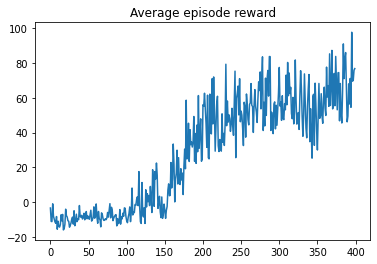

In [13]:
plt.plot(ep_average_rewards)
plt.title('Average episode reward')
plt.show()

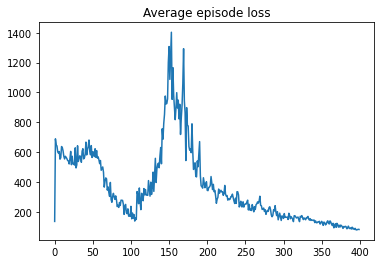

In [14]:
plt.plot(ep_average_losses)
plt.title('Average episode loss')
plt.show()